# Micrograd

### Value Class: 

It is a class that represents scalars and has simple operations defined. The most important thing is that it saves what nodes created this particular value. For example, if we define c as a*b, c will store in _prev which nodes created it. 

Then, using that information, he calculates the gradient with backward from the last node. 
It uses the chain rule to calculate the effect of a node on the final output. In other words, it calculates the derivative of L with respect to that specific node. 

The chain rule is very simple. Imagine we want the derivative of dL/dc, and we have the derivative of the parent, dL/dd. Then, the formula is  
dL/dc = dL/dd * dd/dc. 

For example, if they add, the derivative will be:
    dL/dc = dL/dd * (dd/dc).    
    Since dd/dc is the derivative of a + c with respect to c, which is 1, it is dL/dc = dL/dd * 1 = dL/dd (it doesn't change).    
For multiplication, it is: 
    The derivative of a*c with respect to c is a, so dL/dc = dL/dd * a.

We call the derivative with respect to a node the gradient. To calculate it, we need to go back from the last node to the beginning, expanding the graph while calculating the derivative. To achieve this order, we use a simple topological sort that provides a list of nodes such that the next node in the list is always a child of the current node. It's very simple. Then, we visit each node in reverse order because we start from the last one. 

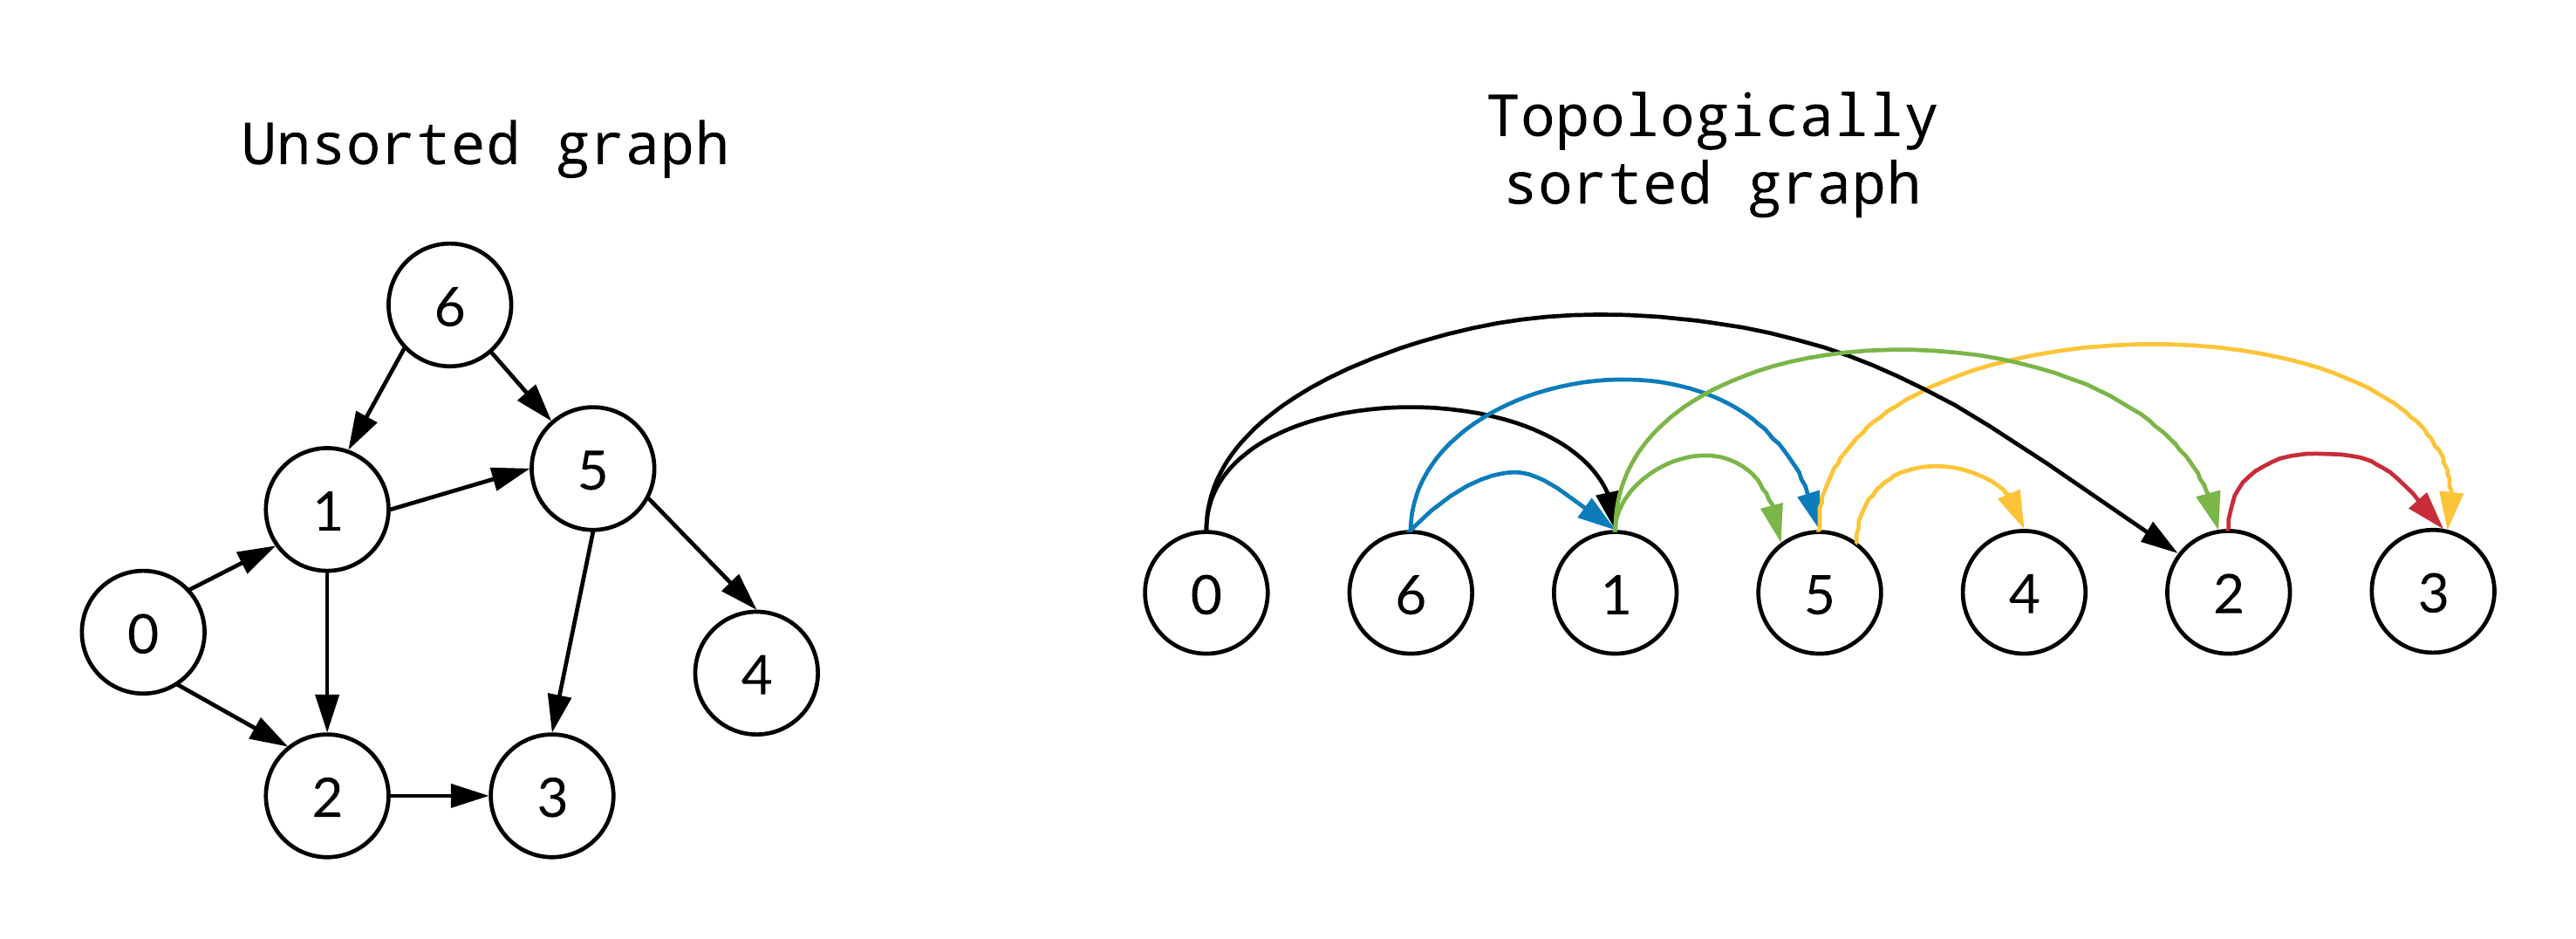

In [37]:
import math 

class Value: 

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)                 # He uses "_" for all the variables that should be private but that thing doesn't exist on python 
        self._op = _op                              # If you put two: "__hola" python rename it to _Value__hola, so if you write __hola throw an error saying it doesn't exist (but you can access it with the weird name _Value__hola )
        self._backward = lambda : None      #We define a function that does nothing
        self._label = label
        self.grad = 0.0
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other)     # With this we can introduce just scalars as other and everything should work 
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward(): 
            self.grad += out.grad*1     #Chain rule with add / We use += because the gradient is added if it is use this node more than one: a+a=b => grad(a) = grad(b) * 2 = grad(b) + grad(b)
            other.grad += out.grad*1
        out._backward = _backward
        return out
    
    def __mul__ (self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward(): 
            self.grad += out.grad * other.data     #Chain rule with mul 
            other.grad += out.grad* self.data
        out._backward = _backward

        return out

    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __neg__(self): # -self
        return self * -1
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self): 
        x = self.data
        t = ((math.exp(2*x)-1) / (math.exp(2*x)+1))      #The mathematical expression of tanh
        out = Value(t, (self,), 'tanh')

        # The derivate of tanh
        def _backward(): 
            self.grad += (1 - t**2)* out.grad   # 1- tanh(x)^2  * parent 
        out._backward = _backward

        return out 


    # Use topological sort to create the order to call the backward 
    def backward(self):
        topo = []
        visited = set()
        def buildTopo(v):
            if v not in visited: 
                visited.add(v)
                for childrens in v._prev:
                    buildTopo(childrens)
                topo.append(v)
        buildTopo(self)     #creamos la lista que vamos a recorrer
        self.grad = 1.0    #L siempre tiene derivada 1 con respecto de L 
        for node in reversed(topo):
            node._backward()

    # Is just a print function to see what it is happening
    def printValue (self):
        print (f"Label: {self._label}")
        print (f"Value: {self.data}")
        print (f"Children: {self._prev}")
        print (f"Operation: {self._op}")
        print (f"Grad: {self.grad}")
        print()
        



In [38]:
a = Value(3) ;a._label = 'a'
b= Value(2) ;b._label = 'b'
c = a*b 
c  =Value(10) ; c._label = 'c'
d = a*b + c ; d._label = 'd'

j = d.tanh()    ; j._label = 'j'
d.printValue()



Label: d
Value: 16
Children: {Value(data=6), Value(data=10)}
Operation: +
Grad: 0.0



In [39]:
j.backward()

d.printValue()
a.printValue()
c.printValue()
j.printValue()

Label: d
Value: 16
Children: {Value(data=6), Value(data=10)}
Operation: +
Grad: 5.062616992290714e-14

Label: a
Value: 3
Children: set()
Operation: 
Grad: 1.0125233984581428e-13

Label: c
Value: 10
Children: set()
Operation: 
Grad: 5.062616992290714e-14

Label: j
Value: 0.9999999999999747
Children: {Value(data=16)}
Operation: tanh
Grad: 1.0



Pytorch is the same as micrograd but with Tensors (n-dimensional arrays) and more efficient

In [40]:
import torch 

In [41]:

a = torch.Tensor([3.0]).double()               ; a.requires_grad = True
b = torch.Tensor([2.0]).double ()              ; b.requires_grad = True
c = torch.Tensor([10.0]).double ()             ; c.requires_grad = True
d = a*b + c
j = torch.tanh(d)

print (j.data.item())
j.backward()

print ('----')
print ('c', c.grad.item())
print ('a', a.grad.item())

#ITS THE SAMEEE

0.9999999999999747
----
c 5.062616992290714e-14
a 1.0125233984581428e-13


## We can create a Neuron

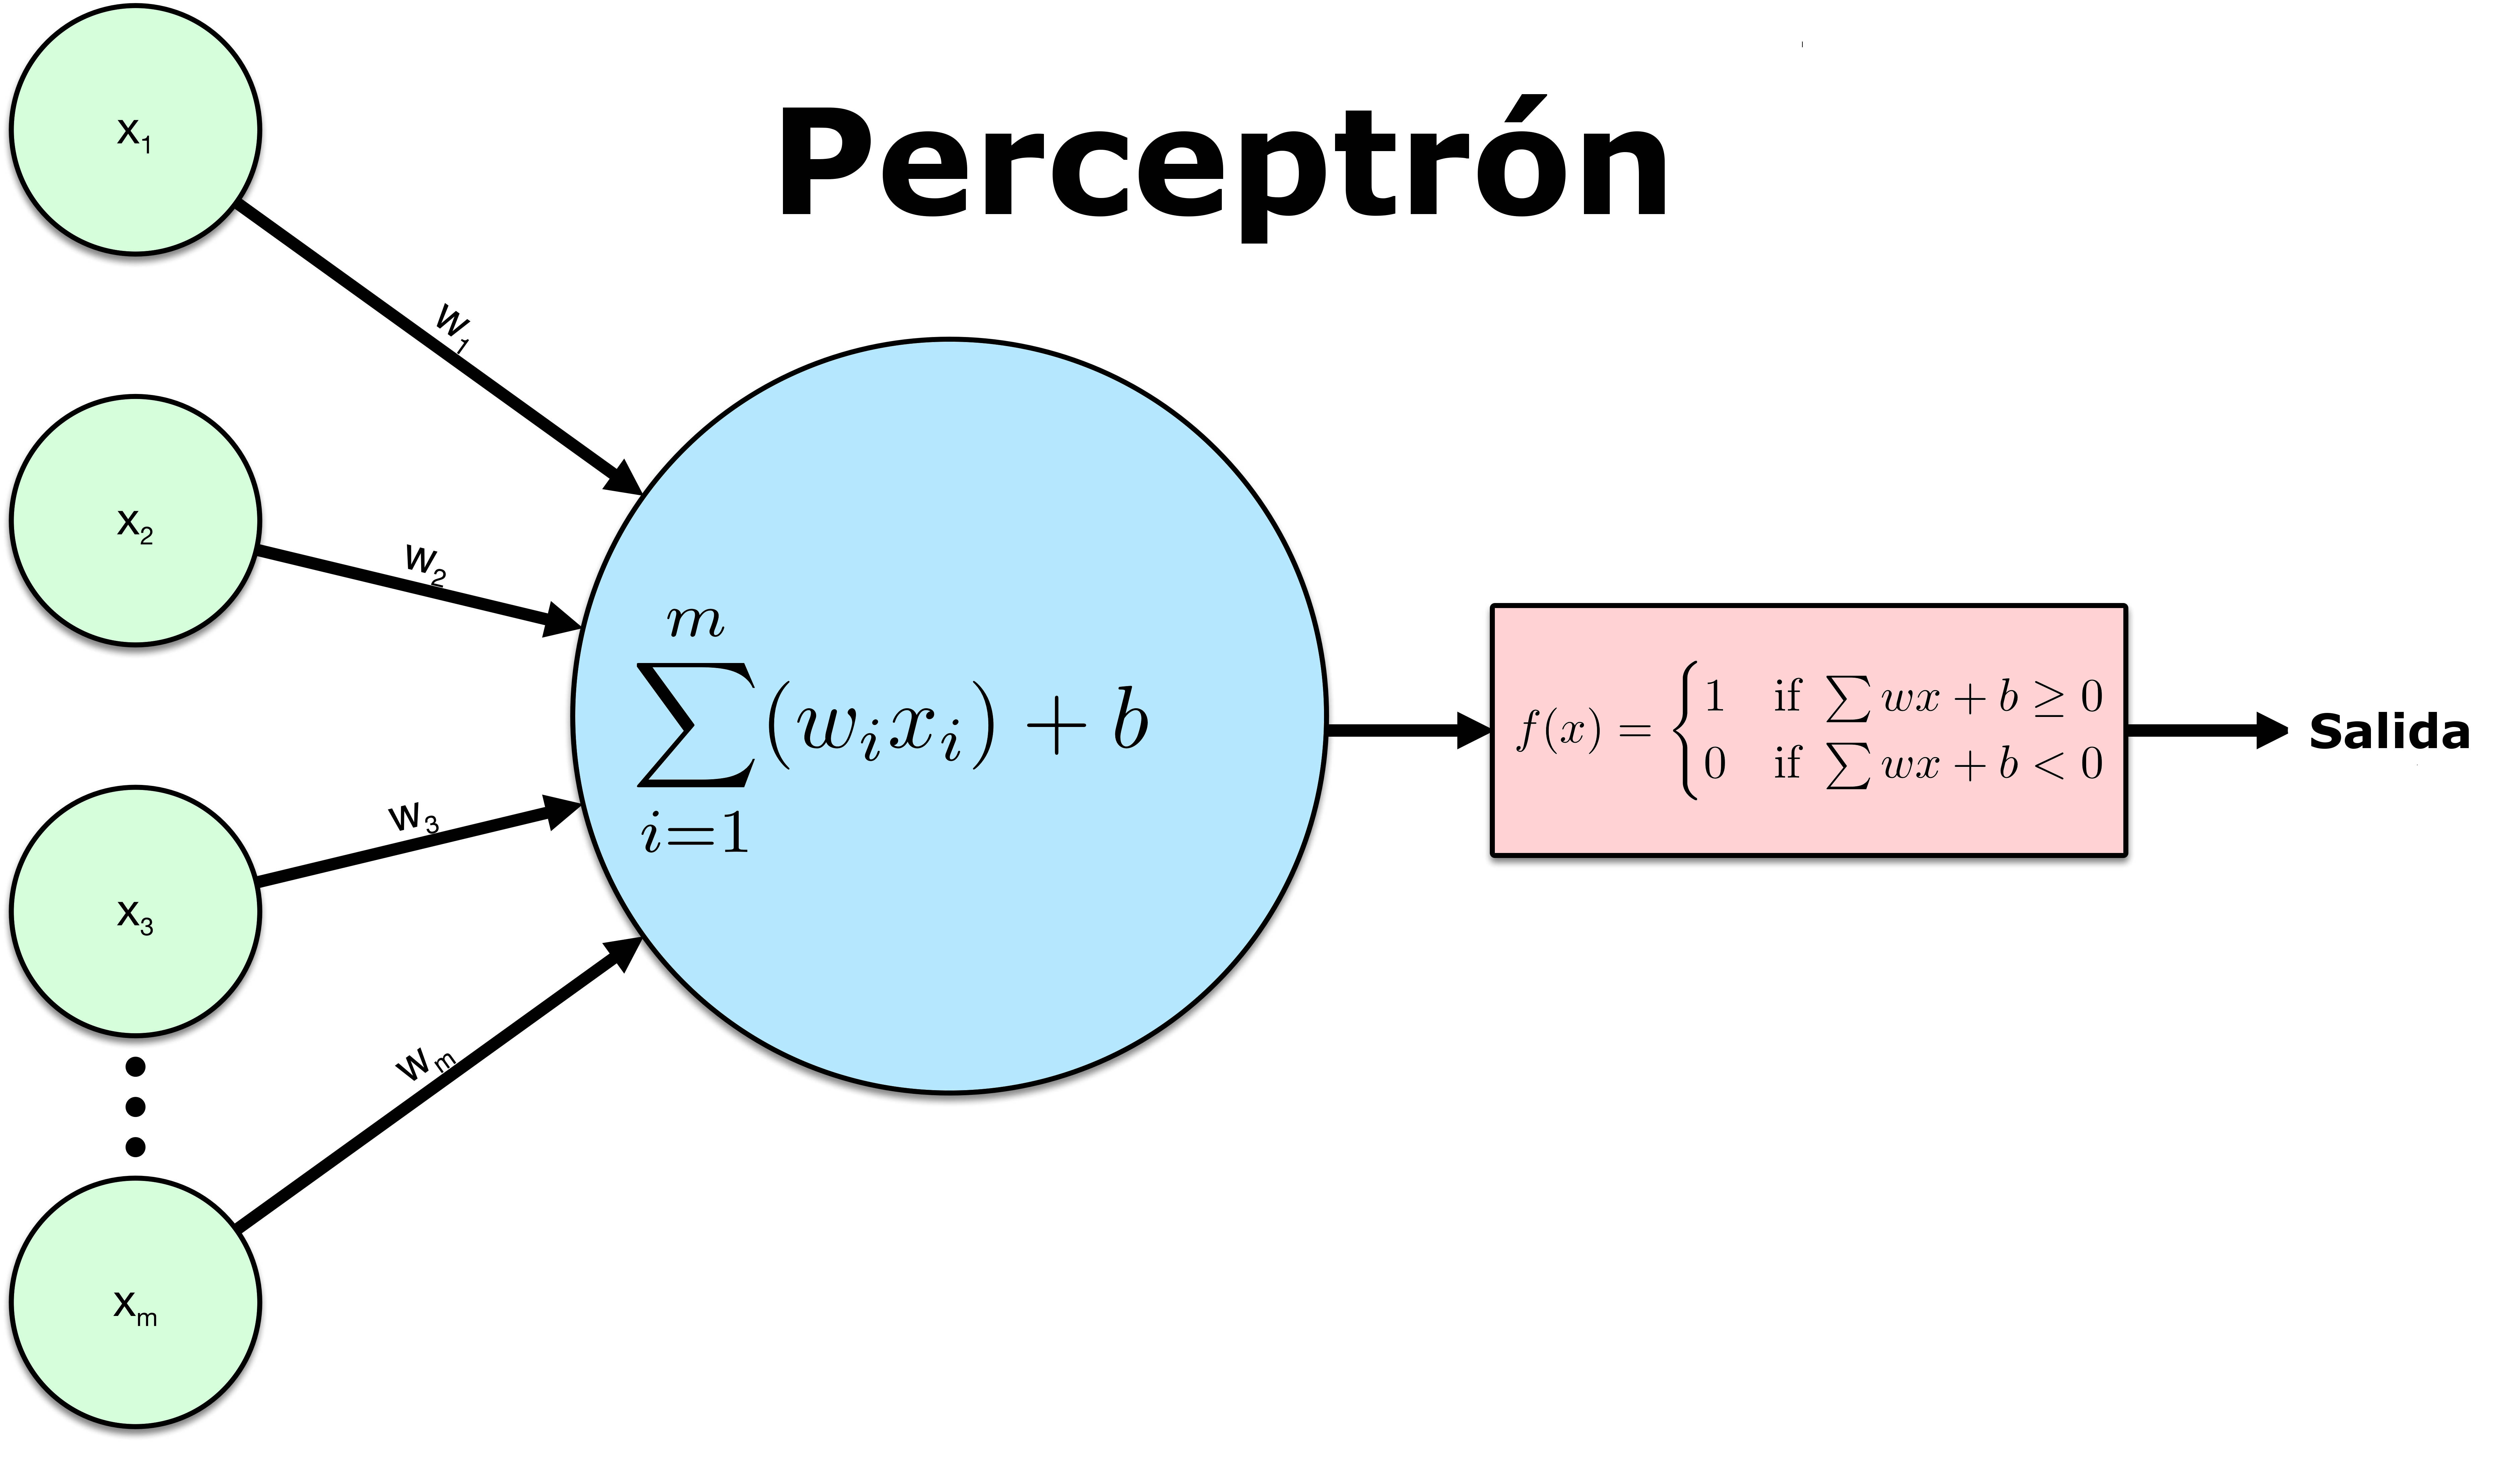



In [42]:
#A neuron with two inputs (x1,x2) , two weights and one bias using tanh as the activation function

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

n.printValue()
x1.printValue()

Label: 
Value: 0.8813735870195432
Children: {Value(data=-6.0), Value(data=6.881373587019543)}
Operation: +
Grad: 0.4999999999999999

Label: x1
Value: 2.0
Children: set()
Operation: 
Grad: -1.4999999999999996



## Now we want a multilayer perceptron to build a neural network 

We define a new class neuron with: 
- init -> initialice the weights and the bias ramdonly, has a nin value that is the number of inputs  
- call ->
    - Introduce the inputs and use zip to build a list of tuples where each weight get assigment with one input
    - Sum all the weights and inputs and apply the activation function (tanh in this case) return the final value
    - Sum start in zero, so to be more efficient we could tell to start in the bias 

To create a layer of neurons he just create a class layer that is a list of neuron with nin and nout
- Init -> initialice the neuron with a for and has a value nout of how many neuron we want (or how many outputs)
- Call -> Is a for that call each neuron with the inputs

We create the MLP, or a multilayer perceptron. This is basically a list of layers that starts with the number of inputs and a list of the number of outputs of each layer. 
- Init -> 2 values, sz that is a list with the number of inputs first and the list of outputs: [nin] + nouts, and layers that is a list of layers 
- Call -> Is a for that call each layer with the inputs

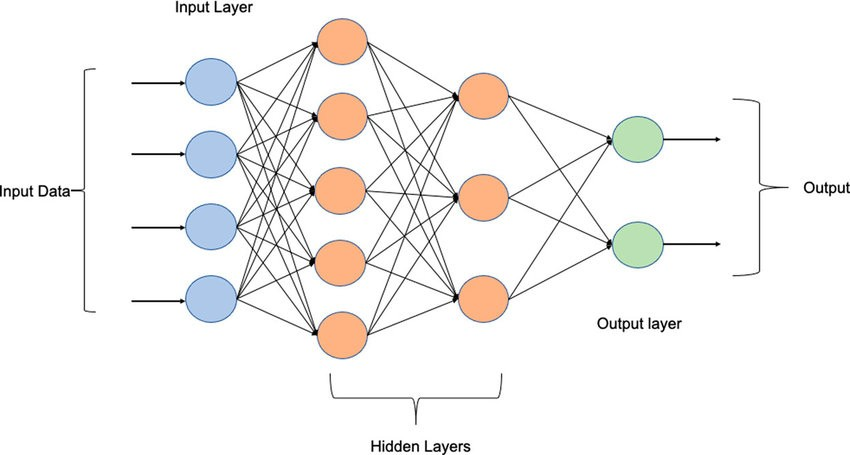

In [43]:
import math
import random

class Neuron: 
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]      #Define the weights randomly
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # act = w * x + b 
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)    # zip the w and x => create a list [(x1,w1), .... , (xn,wn)] and sum each xi*wi multiplication (is a vector multiplication) starting from the bias
        out = act.tanh()
        return out
    
    # For the training
    def parameters(self):
        return self.w + [self.b]

# List of neurons
class Layer:
    def __init__ (self, nin, nout ):
        self.layer = [ Neuron(nin) for _ in range (nout)]   # You can start a class like Neuron (nin)

    def __call__(self, x):
        outs = [n(x) for n in self.layer ]
        # return outs    
        return outs[0] if len(outs) == 1 else outs      #  If there's only one output, it returns a number.   
    
    def parameters(self):
        parameters = []
        for n in self.layer:
            parameters.extend(n.parameters())
        return parameters
    
#List of layers
class MLP: 
    def __init__(self, nin, nouts):
        self.sz = [nin] + nouts
        self.layers = [Layer(self.sz[i],self.sz[i+1]) for i in range (len(nouts))]
    
    def __call__(self, x):
        # First, add the input to the first layer. Then, use that result to add the input to the second layer. 
        for layer in self.layers:   
            x = layer(x)
        return x
    
    def parameters(self):
        parameters = []
        for l in self.layers:
            parameters.extend(l.parameters())
        return parameters

In [44]:
#inputs 
x = [2.0, 3.0, -1.0]
# Number of inputs and and 2 layers with and output of 1
n = MLP(3, [4, 4, 1])
n(x)


Value(data=-0.5952078100358487)

## Training the net
Now we want to train the net. To do that, first we need an objective. For example, for the inputs x1, x2, and x3, we should get the outputs: r1= 1, r2 = -1, r3 = 1. To know how good or bad we did, we use a loss function, specifically the quadratic error (Mean Squared Error): loss = sum((target - output)**2) If it is zero, then the outputs are basically the same as the goals.

The gradient of each weight tells us how much the loss will change if we add a small number to the weight. The gradient is a vector that points in the direction where the loss function increases. Therefore, to minimize the error (decrease the function), we need to go in the opposite direction of the gradient. In other words, we need to recalculate the weights by subtracting the gradient multiplied by a small quantity (learning rate).

If we do this many times, we are going to get closer to the outputs that we want.

We need to modify the class neuron, to get the value of the weights


In [45]:
# Four different inputs with 4 tarjets
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [46]:
ypred = [n(x) for x in xs]
print(ypred)
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))   
print(loss)


[Value(data=-0.5952078100358487), Value(data=-0.8411832439935453), Value(data=-0.7440943169282849), Value(data=0.07739123233353669)]
Value(data=3.4866053759912132)


In [47]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  # Loss funcion is the sum of the cuadratic error for each input 
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))   
  
  # backward pass
  # First we reset the grad of each parameter REMEMBER IT!!!!
  for p in n.parameters():    
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)


0 3.4866053759912132
1 5.3121548192428305
2 0.3466162992725724
3 0.05331327728455837
4 0.04258746924301379
5 0.035792252538445785
6 0.031054282211019187
7 0.027539102107871406
8 0.024814304851047568
9 0.0226320206927529
10 0.020839405655352215
11 0.019336825733898992
12 0.018056417939838858
13 0.016950281638132975
14 0.015983591488670523
15 0.015130388233169133
16 0.014370903480057918
17 0.013689801988828007
18 0.013074993264269523
19 0.012516807792750165


In [48]:
print (ypred)
# Very similar to what we wanted 

[Value(data=0.937398728316716), Value(data=-0.9590826633948943), Value(data=-0.9536632445126556), Value(data=0.9308873004981257)]


In [1]:
from micrograd.engine import Value as v
from micrograd.nn import MLP as mlp
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

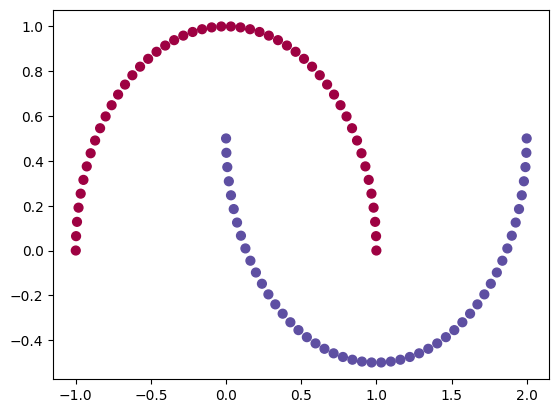

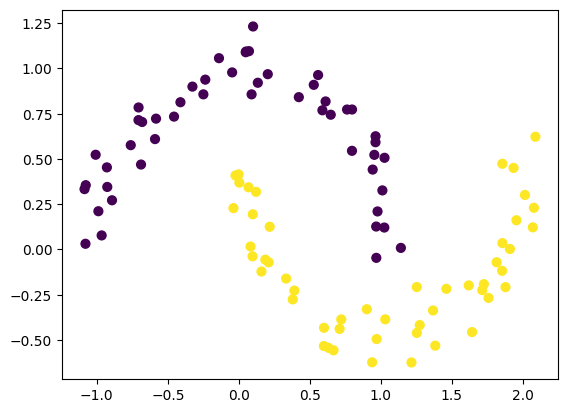

In [27]:
# 0 Noise
# 1. Generate Data
X, y = make_moons(n_samples=100, noise=0)     # Make two interleaving half circles
y = y*2 - 1 # make y be -1 or 1
# visualize in 2D

# 2. Visualize it
plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

X, y = make_moons(n_samples=100, noise=0.1)     # Make two interleaving half circles
y = y*2 - 1 # make y be -1 or 1

# X is a list of tuples in this case of 100 tuples, with each one being the cordinates (xi,yi)
# Y is a list of lables, that has a 1 for one circle and 0 for the other.

# 2. Visualize it
plt.scatter(X[:,0], X[:,1], c=y, s=40)
plt.show()

# With X[:,0] we take the first number, the x's, from all the tuples 
# With X[:,1] we take the seconnd column the y's
# c is the color, we want that like the list of labels y
# s is the size of the dots
# cmap is the pallet of colors, in this case red and blue



In [28]:
# 3. Wrap it in your Value object
inputs = []
for i in range(len(X)):
    # Convert [x1, x2] to [Value(x1), Value(x2)]
    inputs.append([v(X[i][0]), v(X[i][1])])
    
# Targets: y is 0 or 1. If 0 -> target -1.0. If 1 -> target 1.0
targets = [1.0 if yi > 0 else -1.0 for yi in y]

# I have 100 items with two inputs and 1 tarjet per input

In [29]:

# I have 100 items with two inputs and 1 tarjet per input

nn = mlp(2, [16,16,1])
learning_rate = 0.1
for k in range(5):
    nResolults = [nn(i) for i in inputs]
    loss = sum((nResolults[i]-targets[i] )**2 for i in range(len(targets)) )

    nn.zero_grad()
    loss.backward()

    for p in (nn.parameters()):
        p.data += -(learning_rate * p.grad)

    print (f"Step {k}: Loss {loss.data:.4f}")
    
# With a big learning rate it explotes 

Step 0: Loss 190.8597
Step 1: Loss 58415884.0474
Step 2: Loss 36604978939689407654920192.0000
Step 3: Loss 647834229517737862039764386628661984577173064151032181274342046501622832719076441031757004800.0000
Step 4: Loss 60699137067490304991897654523893545718737214550922321678570724660359016059577642122903826726912.0000


In [11]:
nn = mlp(2, [16,16,1])
learning_rate = 0.0001
for k in range(20):
    nResolults = [nn(i) for i in inputs]
    loss = sum((nResolults[i]-targets[i] )**2 for i in range(len(targets)) )

    nn.zero_grad()
    loss.backward()

    for p in (nn.parameters()):
        p.data += -(learning_rate * p.grad)

    print (f"Step {k}: Loss {loss.data:.4f}")
    

Step 0: Loss 435.4234
Step 1: Loss 233.9938
Step 2: Loss 153.8159
Step 3: Loss 117.7621
Step 4: Loss 100.5813
Step 5: Loss 91.3411
Step 6: Loss 85.6310
Step 7: Loss 81.5230
Step 8: Loss 78.1995
Step 9: Loss 75.3204
Step 10: Loss 72.7207
Step 11: Loss 70.3309
Step 12: Loss 68.0375
Step 13: Loss 65.8916
Step 14: Loss 63.8953
Step 15: Loss 62.0066
Step 16: Loss 60.2161
Step 17: Loss 58.5000
Step 18: Loss 56.8462
Step 19: Loss 55.2472


In [30]:
# Variable learning rate
nn = mlp(2, [16,16,1])
learning_rate = 0.0001
for k in range(100):
    nResolults = [nn(i) for i in inputs]
    loss = sum((nResolults[i]-targets[i] )**2 for i in range(len(targets)) )

    nn.zero_grad()
    loss.backward()

    for p in (nn.parameters()):
        p.data += -(learning_rate * p.grad)

    print (f"Step {k}: Loss {loss.data:.4f}")
    
# With a big learning rate it explotes 

Step 0: Loss 981.9812
Step 1: Loss 459.8043
Step 2: Loss 322.2681
Step 3: Loss 260.6415
Step 4: Loss 226.2617
Step 5: Loss 204.2281
Step 6: Loss 189.0417
Step 7: Loss 177.2909
Step 8: Loss 167.9721
Step 9: Loss 160.1293
Step 10: Loss 153.3736
Step 11: Loss 147.5707
Step 12: Loss 142.5023
Step 13: Loss 137.8234
Step 14: Loss 133.5257
Step 15: Loss 129.5728
Step 16: Loss 125.8218
Step 17: Loss 122.3443
Step 18: Loss 119.0087
Step 19: Loss 115.8346
Step 20: Loss 112.7704
Step 21: Loss 109.7862
Step 22: Loss 106.9011
Step 23: Loss 104.1540
Step 24: Loss 101.5009
Step 25: Loss 98.9657
Step 26: Loss 96.4909
Step 27: Loss 94.1503
Step 28: Loss 91.8681
Step 29: Loss 89.5619
Step 30: Loss 87.3982
Step 31: Loss 85.4403
Step 32: Loss 83.5519
Step 33: Loss 81.7541
Step 34: Loss 80.0022
Step 35: Loss 78.2369
Step 36: Loss 76.5881
Step 37: Loss 75.0913
Step 38: Loss 73.6799
Step 39: Loss 72.3590
Step 40: Loss 71.0802
Step 41: Loss 69.8492
Step 42: Loss 68.6718
Step 43: Loss 67.5341
Step 44: Loss 66.

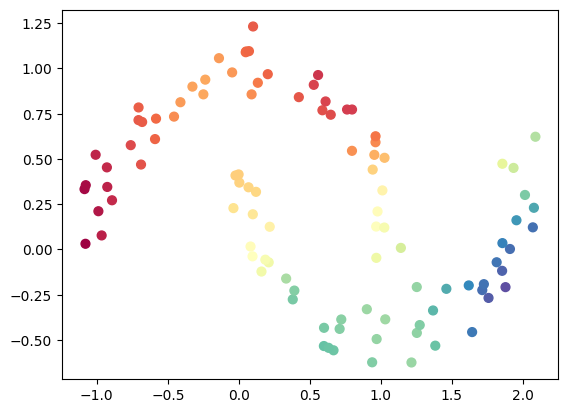

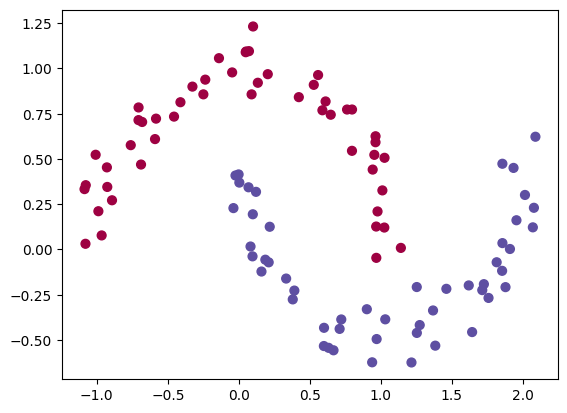

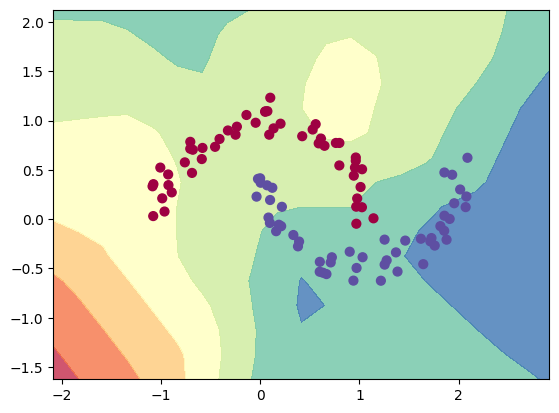

In [31]:
predicciones_numericas = [p.data for p in nResolults]
# 2. Visualize it
plt.scatter(X[:,0], X[:,1], c=predicciones_numericas, s=40, cmap=plt.cm.Spectral)
plt.show()

plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

import numpy as np

# 1. Definir la malla (todos los pixeles del grafico)
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# 2. Preguntar a la red qué opina de cada pixel
inputs_grid = []
for x1, x2 in zip(xx.ravel(), yy.ravel()):
    # Creamos Values temporales para preguntar a la red
    inputs_grid.append([v(x1), v(x2)])

# Predecimos (esto puede tardar unos segundos)
Z = [nn(x).data for x in inputs_grid] # <--- Aqui extraemos .data directamente

# 3. Dibujar
Z = np.array(Z).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

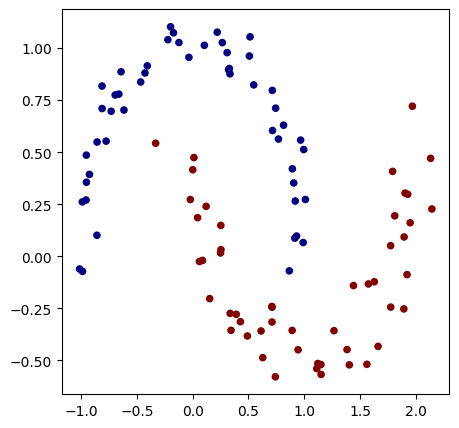

In [34]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')



Calculates the loss using SVM Max-Margin (Hinge Loss) with L2 Regularization.
    
1. Minibatch: Selects a random subset of data to speed up training and add noise (SGD).
2. Hinge Loss: Unlike MSE, this only penalizes predictions that are wrong or not confident enough 
    (margin < 1). Once the model is confident (margin > 1), the loss is zero.
    Formula: max(0, 1 - y * score). For example if a input gets a 1.5, then its very confident about it been 1. But MSE would have penalice that for been too good.
3. L2 Regularization: Penalizes large weights (Weight Decay) to force the model to find 
       simpler, smoother decision boundaries and prevent overfitting.

For binary clasification is the best one

It doesn't work for regresion (temperature, prices...) or text prediction.

In [35]:
model = mlp(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))


# Pro version
# loss function
def loss(batch_size=None):
    
    # 1. Minibatch (Stochastic Gradient Descent)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    # Forward pass
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    scores = list(map(model, inputs))
    
    # 2. SVM "Max-Margin" Loss (Hinge Loss)
    # We want the score to be > 1 for positive class and < -1 for negative class.
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # 3. L2 Regularization (Weight Decay)
    # Keeps weights small to ensure a smooth boundary.
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    
    total_loss = data_loss + reg_loss
    
    # Accuracy check
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)


MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337
Value(data=1.262801872795652) 0.5


In [37]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.4359016927799273, accuracy 81.0%
step 1 loss 0.4010488813719904, accuracy 80.0%
step 2 loss 0.46286240324055455, accuracy 81.0%
step 3 loss 0.35490488222117406, accuracy 81.0%
step 4 loss 0.32422809233284083, accuracy 81.0%
step 5 loss 0.39235230994351716, accuracy 82.0%
step 6 loss 0.27525399166854425, accuracy 83.0%
step 7 loss 0.24220390945818226, accuracy 96.0%
step 8 loss 0.2934948189661981, accuracy 89.0%
step 9 loss 0.1610343410640222, accuracy 96.0%
step 10 loss 0.15109519099792595, accuracy 94.0%
step 11 loss 0.4371982254186156, accuracy 81.0%
step 12 loss 0.9427485688835835, accuracy 74.0%
step 13 loss 0.43015876833619604, accuracy 82.0%
step 14 loss 0.33455550589022054, accuracy 83.0%
step 15 loss 0.2696318286858724, accuracy 83.0%
step 16 loss 0.21569019767752634, accuracy 94.0%
step 17 loss 0.17415173787436541, accuracy 98.0%
step 18 loss 0.1386485677007425, accuracy 98.0%
step 19 loss 0.10913805613224524, accuracy 98.0%
step 20 loss 0.14666745913800244, accu

(-1.5786301298561791, 1.9213698701438209)

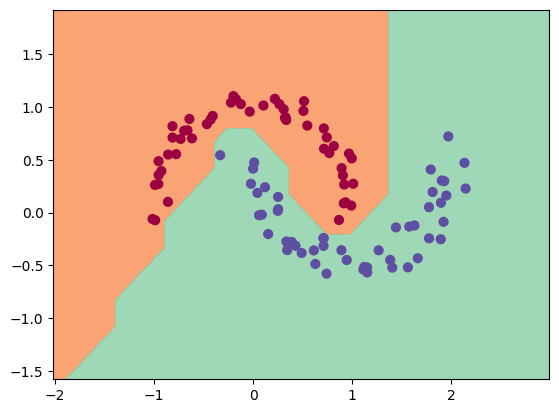

In [39]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(v, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

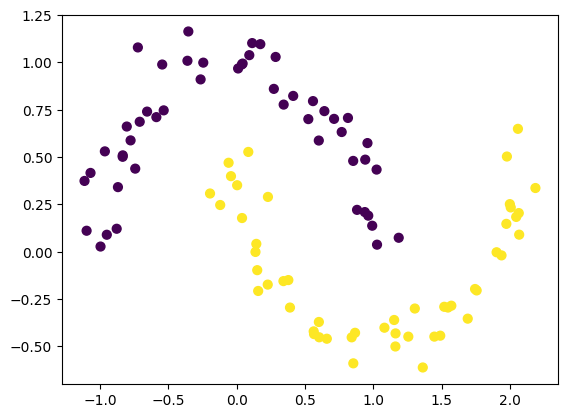

In [2]:
# Train with tanh

X, y = make_moons(n_samples=100, noise=0.1)     # Make two interleaving half circles
y = y*2 - 1 # make y be -1 or 1
# 2. Visualize it
plt.scatter(X[:,0], X[:,1], c=y, s=40)
plt.show()


In [5]:

# I have 100 items with two inputs and 1 tarjet per input
# 3. Wrap it in your Value object
inputs = []
for i in range(len(X)):
    # Convert [x1, x2] to [Value(x1), Value(x2)]
    inputs.append([v(X[i][0]), v(X[i][1])])
    
# Targets: y is 0 or 1. If 0 -> target -1.0. If 1 -> target 1.0
targets = [1.0 if yi > 0 else -1.0 for yi in y]

# I have 100 items with two inputs and 1 tarjet per input
nn = mlp(2, [16,16,1])
learning_rate = 0.001
for k in range(50):
    nResolults = [nn(i) for i in inputs]
    loss = sum((nResolults[i]-targets[i] )**2 for i in range(len(targets)) )

    nn.zero_grad()
    loss.backward()

    for p in (nn.parameters()):
        p.data += -(learning_rate * p.grad)

    print (f"Step {k}: Loss {loss.data:.4f}")
    
# With a big learning rate it explotes 

Step 0: Loss 170.9835
Step 1: Loss 102.0297
Step 2: Loss 59.5039
Step 3: Loss 47.5456
Step 4: Loss 43.8222
Step 5: Loss 42.4228
Step 6: Loss 41.3730
Step 7: Loss 40.4419
Step 8: Loss 39.5748
Step 9: Loss 38.7564
Step 10: Loss 37.9815
Step 11: Loss 37.2467
Step 12: Loss 36.5477
Step 13: Loss 35.8798
Step 14: Loss 35.2380
Step 15: Loss 34.6176
Step 16: Loss 34.0145
Step 17: Loss 33.4249
Step 18: Loss 32.8460
Step 19: Loss 32.2752
Step 20: Loss 31.7109
Step 21: Loss 31.1516
Step 22: Loss 30.5966
Step 23: Loss 30.0452
Step 24: Loss 29.4973
Step 25: Loss 28.9529
Step 26: Loss 28.4119
Step 27: Loss 27.8746
Step 28: Loss 27.3411
Step 29: Loss 26.8117
Step 30: Loss 26.2867
Step 31: Loss 25.7661
Step 32: Loss 25.2504
Step 33: Loss 24.7396
Step 34: Loss 24.2340
Step 35: Loss 23.7338
Step 36: Loss 23.2393
Step 37: Loss 22.7505
Step 38: Loss 22.2677
Step 39: Loss 21.7911
Step 40: Loss 21.3210
Step 41: Loss 20.8574
Step 42: Loss 20.4007
Step 43: Loss 19.9508
Step 44: Loss 19.5081
Step 45: Loss 19.0

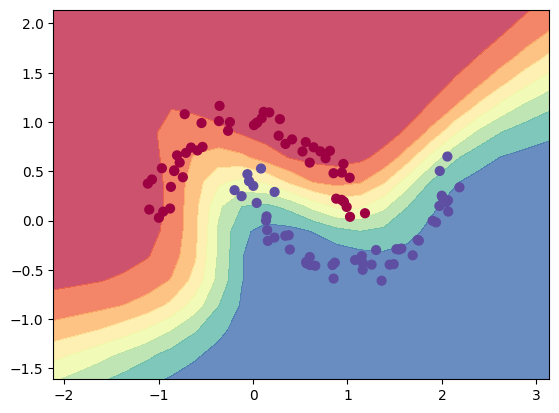

In [7]:

import numpy as np
# Normal tanh is a lot better than relu alone 
# 1. Definir la malla (todos los pixeles del grafico)
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# 2. Preguntar a la red qué opina de cada pixel
inputs_grid = []
for x1, x2 in zip(xx.ravel(), yy.ravel()):
    # Creamos Values temporales para preguntar a la red
    inputs_grid.append([v(x1), v(x2)])

# Predecimos (esto puede tardar unos segundos)
Z = [nn(x).data for x in inputs_grid] # <--- Aqui extraemos .data directamente

# 3. Dibujar
Z = np.array(Z).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()